In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Step 1: Download SPY data
spy_data = yf.download('SPY', start='2014-09-25', end='2024-09-25')

# Step 2: Preprocess the data
data = spy_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = pd.Series(data).diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI to the data
spy_data['RSI'] = calculate_rsi(spy_data['Close'])

# Calculate EMA for 30, 60, and 90 days
spy_data['EMA_30'] = spy_data['Close'].ewm(span=30, adjust=False).mean()
spy_data['EMA_60'] = spy_data['Close'].ewm(span=60, adjust=False).mean()
spy_data['EMA_90'] = spy_data['Close'].ewm(span=90, adjust=False).mean()

# Create sequences
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 5  # using 5 days to predict the next day
X, y = create_sequences(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 3: Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Step 5: Make predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 6: Create a DataFrame to show actual and predicted values
results_df = pd.DataFrame({
    'Actual Prices': actual_prices.flatten(),
    'Predicted Prices': predicted_prices.flatten()
})

# Step 7: Add the dates back to the DataFrame for plotting from 2014
results_df['Date'] = spy_data.index[-len(results_df):]

# Step 8: Visualization with the full date range from 2014
plt.figure(figsize=(14, 8))

# Plot Actual Prices with Date on the x-axis
plt.plot(spy_data.index, spy_data['Close'], color='blue', label='Actual SPY Price')

# Plot Predicted Prices with Date on the x-axis (aligning to the end of the training set)
plt.plot(results_df['Date'], results_df['Predicted Prices'], color='red', label='Predicted SPY Price')

plt.title(f'SPY Price Prediction with Full Date Range from 2014')
plt.xlabel('Date')  # Label the x-axis as Date
plt.ylabel('Price')  # Label the y-axis as Price

# Rotate dates on the x-axis for better readability
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.show()

# Step 9: Evaluation
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f'Root Mean Squared Error: {rmse}')


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0468
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9026e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.2121e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.5745e-04
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8658e-04
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6985e-04
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5948e-04
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - los

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0800e-04
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4590e-04
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7190e-04
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1600e-04
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.6192e-04
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.6388e-04
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.5879e-04
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.0983e-04
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3896e-04
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.5385e-04
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0796e-04
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6959e-04
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7059e-04
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3489e-04
Epoch 15/50
79/79 ━━━━━━━━━━━

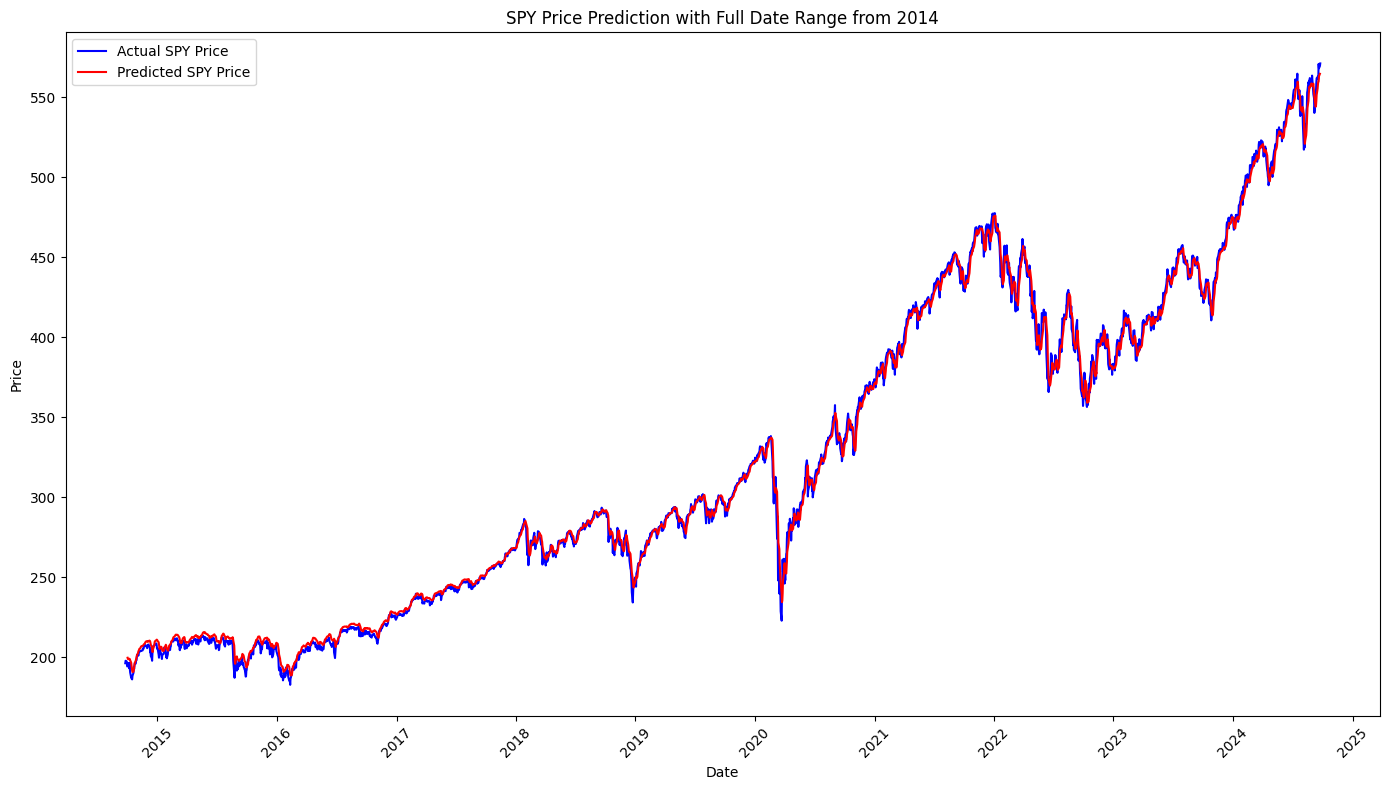

Root Mean Squared Error (Full Period): 4.773151422956376

ML Trend Indicators DataFrame:
        Date  Actual Prices  Predicted Prices Actual Trend Predicted Trend
0 2014-10-02     194.380005        199.787292          N/A             N/A
1 2014-10-03     196.520004        199.004089      Uptrend       Downtrend
2 2014-10-06     196.289993        199.000259    Downtrend       Downtrend
3 2014-10-07     193.259995        199.194122    Downtrend         Uptrend
4 2014-10-08     196.639999        198.509354      Uptrend       Downtrend


In [ ]:
# Step 1: Train the model on the full dataset (remove train/test split)
X_full, y_full = create_sequences(scaled_data, time_step)
X_full = X_full.reshape(X_full.shape[0], X_full.shape[1], 1)

# Train the model on the entire dataset
model.fit(X_full, y_full, epochs=50, batch_size=32)

# Step 2: Use the model to predict prices for the entire dataset
predicted_prices_full = model.predict(X_full)
predicted_prices_full = scaler.inverse_transform(predicted_prices_full)
actual_prices_full = scaler.inverse_transform(scaled_data[time_step:])

# Ensure lengths match
min_length = min(len(predicted_prices_full), len(actual_prices_full), len(spy_data.index[time_step:]))

predicted_prices_full = predicted_prices_full[:min_length]
actual_prices_full = actual_prices_full[:min_length]
date_range = spy_data.index[time_step:][:min_length]

# Step 3: Create a DataFrame for the full prediction period
full_results_df = pd.DataFrame({
    'Actual Prices': actual_prices_full.flatten(),
    'Predicted Prices': predicted_prices_full.flatten(),
    'Date': date_range  # Align the dates to the predictions
})

# Step 4: Calculate Actual and Predicted Trend
# Calculate actual trend based on actual prices
actual_trend = ['N/A']  # Initialize with 'N/A' for the first value
for i in range(1, len(actual_prices_full)):
    if actual_prices_full[i] > actual_prices_full[i - 1]:
        actual_trend.append('Uptrend')
    else:
        actual_trend.append('Downtrend')

# Calculate predicted trend based on predicted prices
predicted_trend = ['N/A']  # Initialize with 'N/A' for the first value
for i in range(1, len(predicted_prices_full)):
    if predicted_prices_full[i] > predicted_prices_full[i - 1]:
        predicted_trend.append('Uptrend')
    else:
        predicted_trend.append('Downtrend')

# Step 5: Store trend values in ml_trend_indicators
ml_trend_indicators = pd.DataFrame({
    'Date': date_range,
    'Actual Prices': actual_prices_full.flatten(),
    'Predicted Prices': predicted_prices_full.flatten(),
    'Actual Trend': actual_trend,
    'Predicted Trend': predicted_trend
})

# Step 6: Calculate Prediction Accuracy
correct_predictions = 0
total_comparisons = 0

# Start from index 1 to avoid 'N/A'
for i in range(1, len(ml_trend_indicators)):
    if ml_trend_indicators['Actual Trend'].iloc[i] == ml_trend_indicators['Predicted Trend'].iloc[i]:
        correct_predictions += 1
    total_comparisons += 1  # Count each comparison

# Calculate the percentage accuracy
prediction_accuracy = (correct_predictions / total_comparisons) * 100

# Print the accuracy
print(f'Correct Trend Prediction Accuracy: {prediction_accuracy:.2f}%')

# Step 7: Plot the full period with predictions starting from 2014
plt.figure(figsize=(14, 8))

# Plot Actual Prices with Date on the x-axis
plt.plot(spy_data.index, spy_data['Close'], color='blue', label='Actual SPY Price')

# Plot Predicted Prices with Date on the x-axis (aligning from 2014 onwards)
plt.plot(full_results_df['Date'], full_results_df['Predicted Prices'], color='red', label='Predicted SPY Price')

plt.title(f'SPY Price Prediction with Full Date Range from 2014')
plt.xlabel('Date')  # Label the x-axis as Date
plt.ylabel('Price')  # Label the y-axis as Price

# Rotate dates on the x-axis for better readability
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.show()

# Step 8: Evaluate the model using RMSE for the full period
rmse_full = np.sqrt(mean_squared_error(actual_prices_full, predicted_prices_full))
print(f'Root Mean Squared Error (Full Period): {rmse_full}')

# Display the trend output
print("\nML Trend Indicators DataFrame:")
print(ml_trend_indicators.head())  # Display the first few rows of the trend indicator DataFrame


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-3-bd8e1bd23a9c>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy_data.fillna(method='ffill', inplace=True)



Technical Indicators Trend DataFrame:
           Actual Trend Predicted Trend
Date                                   
2015-07-13      Uptrend         Uptrend
2015-07-14      Uptrend         Uptrend
2015-07-15    Downtrend         Uptrend
2015-07-16      Uptrend         Uptrend
2015-07-17      Uptrend         Uptrend
...                 ...             ...
2024-09-18    Downtrend         Uptrend
2024-09-19      Uptrend         Uptrend
2024-09-20    Downtrend         Uptrend
2024-09-23      Uptrend         Uptrend
2024-09-24      Uptrend         Uptrend

[2317 rows x 2 columns]
Trend Indicator Success Rate: 53.60%
Momentum Indicator Success Rate: 43.07%
Volatility Indicator Success Rate: 57.36%
Volume Indicator Success Rate: 100.00%
Combined Signal Success Rate: 53.60%


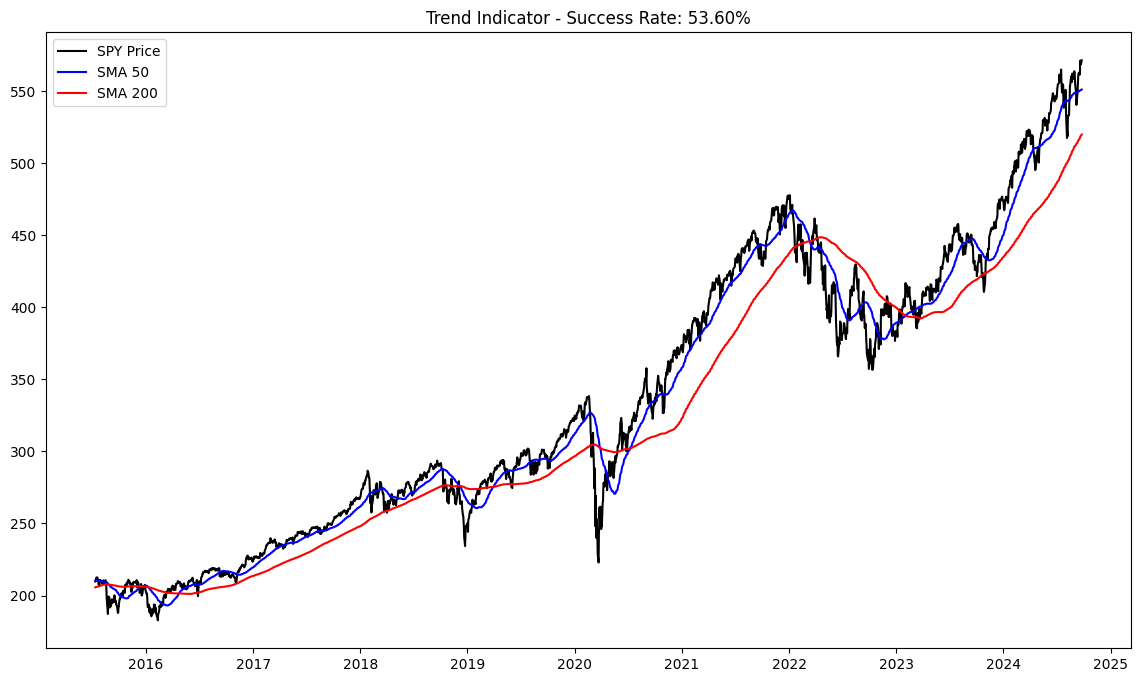

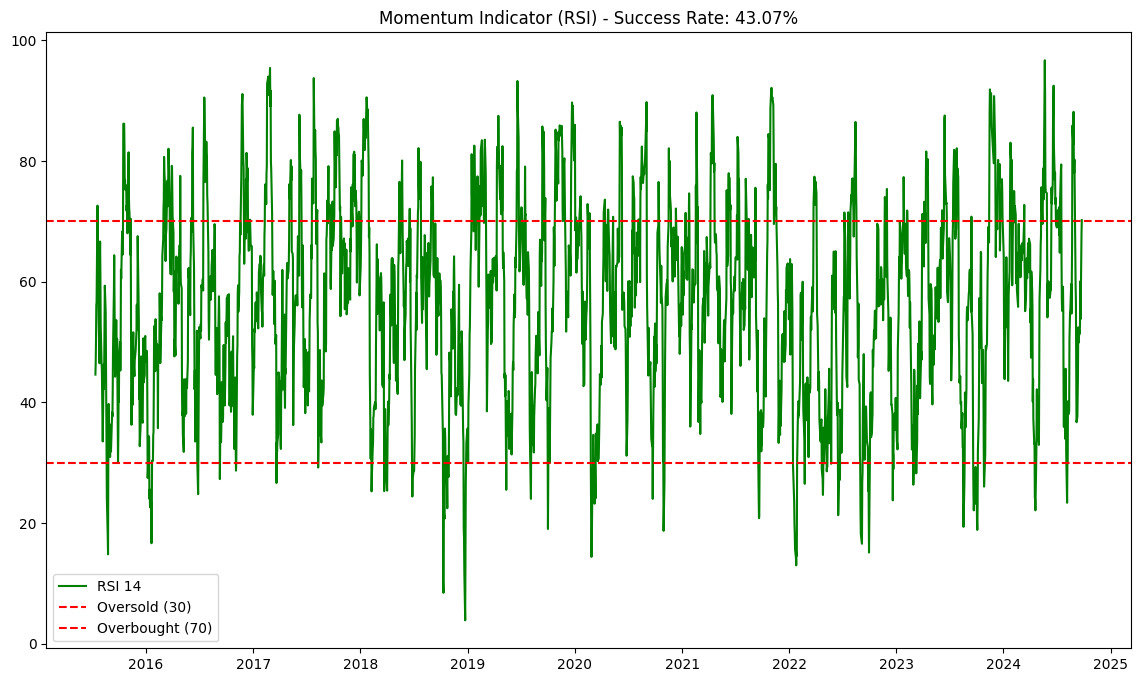

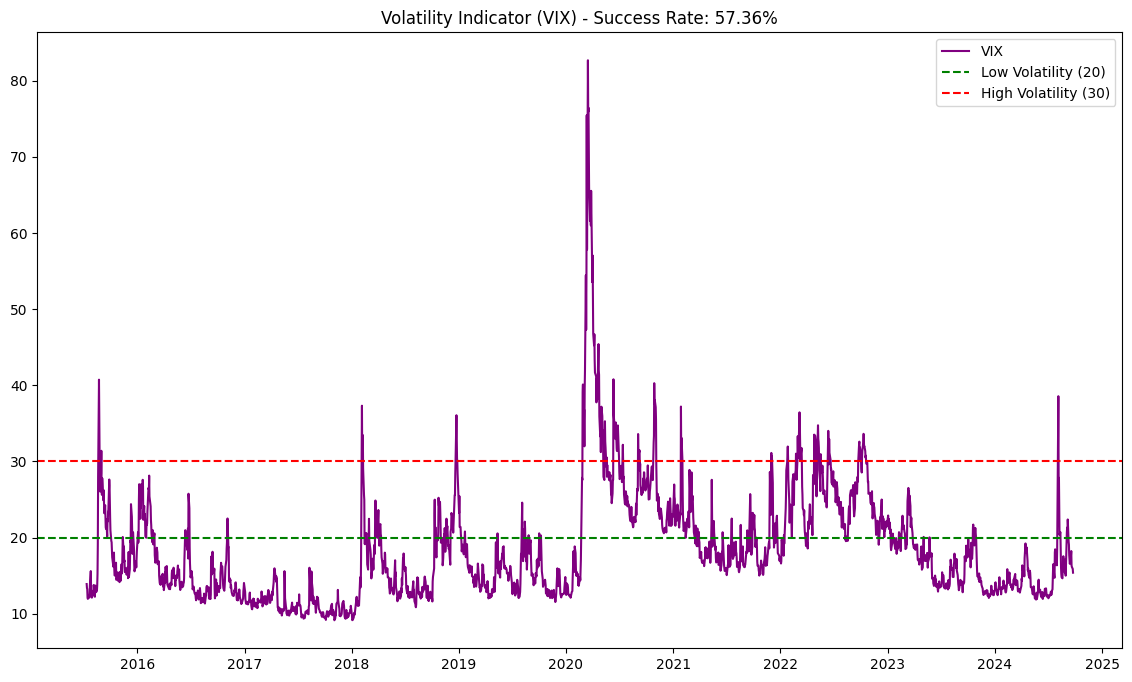

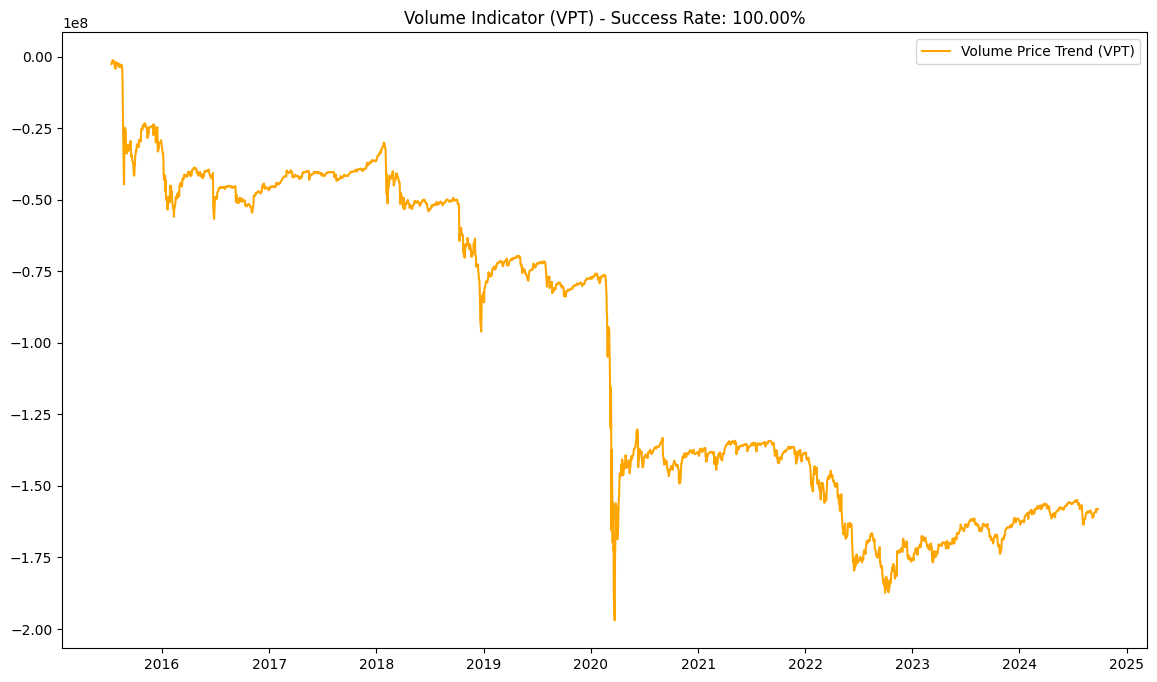

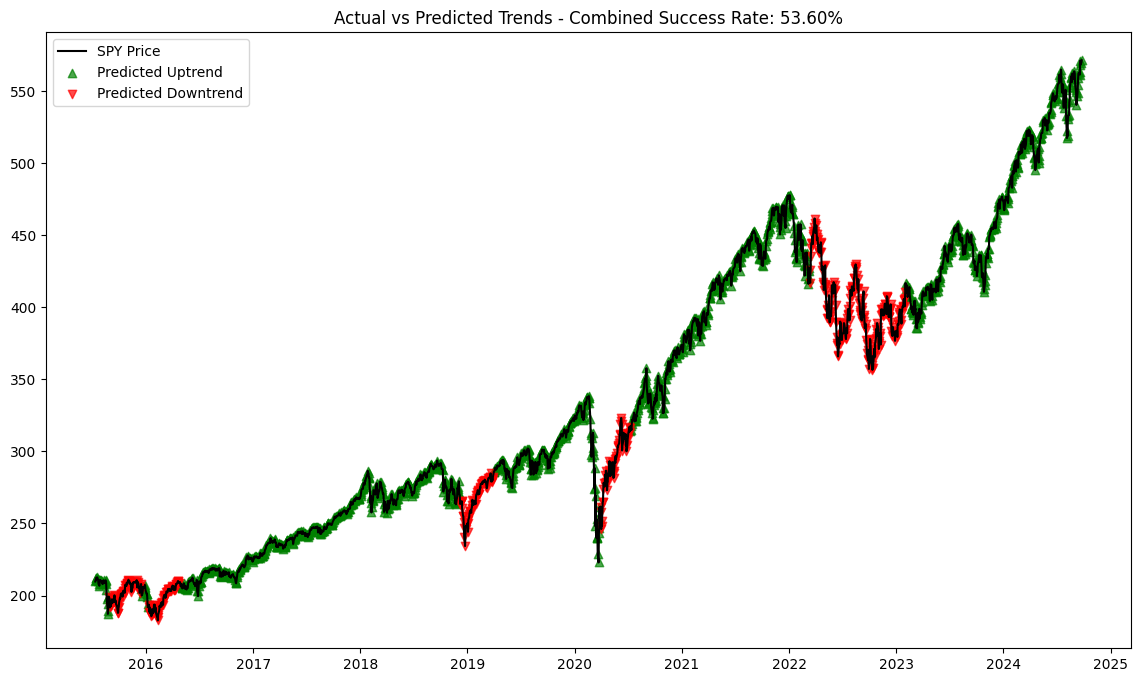

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download SPY and VIX data
spy_data = yf.download('SPY', start='2014-09-25', end='2024-09-25')
vix_data = yf.download('^VIX', start='2014-09-25', end='2024-09-25')

# Align VIX data with SPY data
vix_data = vix_data.reindex(spy_data.index, method='ffill')

# Calculate Technical Indicators

# 1. Trend Indicators: Simple Moving Averages (SMA 50 and SMA 200)
spy_data['SMA_50'] = spy_data['Close'].rolling(window=50).mean()
spy_data['SMA_200'] = spy_data['Close'].rolling(window=200).mean()

# 2. Momentum Indicators: Relative Strength Index (RSI 14)
def calculate_rsi(data, window=14):
    delta = pd.Series(data).diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

spy_data['RSI_14'] = calculate_rsi(spy_data['Close'])

# 3. Volatility Indicator: VIX (Volatility Index)
spy_data['VIX'] = vix_data['Close']

# 4. Volume Indicator: Volume Price Trend (VPT)
# VPT formula: Cumulative ((Close - Prev_Close) / Prev_Close) * Volume
spy_data['VPT'] = ((spy_data['Close'].pct_change()) * spy_data['Volume']).cumsum()

# Fill NaN values created by rolling windows with forward fill to avoid issues
spy_data.fillna(method='ffill', inplace=True)

# Combine Technical Indicators to Generate Signals
def generate_signals(df):
    df['Trend_Signal'] = np.where(df['SMA_50'] > df['SMA_200'], 1, -1)  # 1: Uptrend, -1: Downtrend
    df['Momentum_Signal'] = np.where(df['RSI_14'] < 30, 1, np.where(df['RSI_14'] > 70, -1, 0))  # RSI signals
    df['Volatility_Signal'] = np.where(df['VIX'] < 20, 1, np.where(df['VIX'] > 30, -1, 0))  # VIX signals
    df['Volume_Signal'] = np.where(df['VPT'] > df['VPT'].shift(1), 1, -1)  # VPT signals
    return df

spy_data = generate_signals(spy_data)

# Assign Weights Based on Indicator Success
weights = {'Trend_Signal': 0.4, 'Momentum_Signal': 0.2, 'Volatility_Signal': 0.1, 'Volume_Signal': 0.1}

# Combine Signals Using Weights
spy_data['Combined_Signal'] = (spy_data['Trend_Signal'] * weights['Trend_Signal'] +
                               spy_data['Momentum_Signal'] * weights['Momentum_Signal'] +
                               spy_data['Volatility_Signal'] * weights['Volatility_Signal'] +
                               spy_data['Volume_Signal'] * weights['Volume_Signal'])

# Determine Final Trend Prediction
spy_data['Predicted_Trend'] = np.where(spy_data['Combined_Signal'] > 0, 'Uptrend', 'Downtrend')

# Calculate Actual Trend Based on Close Price
spy_data['Actual_Trend'] = np.where(spy_data['Close'] > spy_data['Close'].shift(1), 'Uptrend', 'Downtrend')

# Remove the first row because of NaN values from shift and rolling windows
spy_data.dropna(inplace=True)

# Store the trend outputs in ti_trend_indicators
ti_trend_indicators = pd.DataFrame({
    #'Date': spy_data.index,
    'Actual Trend': spy_data['Actual_Trend'],
    'Predicted Trend': spy_data['Predicted_Trend']
})

# # Print the DataFrame containing the trend outputs
# print("\nTechnical Indicators Trend DataFrame:")
# print(ti_trend_indicators)
# output_file = "technical_indicators_trends.xlsx"
# # Export the DataFrame to an Excel file
# ti_trend_indicators.to_excel(output_file, index=False)
# # Download the file
# files.download(output_file)


# ti_trend_indicators = pd.DataFrame({
#     'Date': ['2024-01-01', '2024-01-02', '2024-01-03'],
#     'Actual Trend': ['Uptrend', 'Downtrend', 'Uptrend'],
#     'Predicted Trend': ['Uptrend', 'Uptrend', 'Downtrend']
# })

# Print the DataFrame containing the trend outputs
print("\nTechnical Indicators Trend DataFrame:")
print(ti_trend_indicators)

# # Export the DataFrame to an Excel file
# output_file = "technical_indicators_trends.xlsx"
# ti_trend_indicators.to_excel(output_file, index=False)

# # Download the file
# files.download(output_file)

# Backtest: Calculate Success Rate for Each Indicator
def calculate_success_rate(signal, actual_trend):
    # Compare signal (1, -1) to actual trend ('Uptrend', 'Downtrend')
    signal_trend = np.where(signal > 0, 'Uptrend', 'Downtrend')
    correct_predictions = np.sum(signal_trend == actual_trend)
    total_predictions = len(actual_trend)
    success_rate = (correct_predictions / total_predictions) * 100
    return success_rate

# Ensure that the actual trends are properly aligned
trend_success_rate = calculate_success_rate(spy_data['Trend_Signal'], spy_data['Actual_Trend'])
momentum_success_rate = calculate_success_rate(spy_data['Momentum_Signal'], spy_data['Actual_Trend'])
volatility_success_rate = calculate_success_rate(spy_data['Volatility_Signal'], spy_data['Actual_Trend'])
volume_success_rate = calculate_success_rate(spy_data['Volume_Signal'], spy_data['Actual_Trend'])
combined_success_rate = calculate_success_rate(spy_data['Combined_Signal'], spy_data['Actual_Trend'])

# Print Success Rates
print(f"Trend Indicator Success Rate: {trend_success_rate:.2f}%")
print(f"Momentum Indicator Success Rate: {momentum_success_rate:.2f}%")
print(f"Volatility Indicator Success Rate: {volatility_success_rate:.2f}%")
print(f"Volume Indicator Success Rate: {volume_success_rate:.2f}%")
print(f"Combined Signal Success Rate: {combined_success_rate:.2f}%")

# Plot Indicator Performance and Trends

# Plot Trend Indicator (SMA)
plt.figure(figsize=(14, 8))
plt.plot(spy_data['Close'], label='SPY Price', color='black')
plt.plot(spy_data['SMA_50'], label='SMA 50', color='blue')
plt.plot(spy_data['SMA_200'], label='SMA 200', color='red')
plt.title(f'Trend Indicator - Success Rate: {trend_success_rate:.2f}%')
plt.legend()
plt.show()

# Plot Momentum Indicator (RSI)
plt.figure(figsize=(14, 8))
plt.plot(spy_data['RSI_14'], label='RSI 14', color='green')
plt.axhline(30, linestyle='--', color='red', label='Oversold (30)')
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
plt.title(f'Momentum Indicator (RSI) - Success Rate: {momentum_success_rate:.2f}%')
plt.legend()
plt.show()

# Plot Volatility Indicator (VIX)
plt.figure(figsize=(14, 8))
plt.plot(spy_data['VIX'], label='VIX', color='purple')
plt.axhline(20, linestyle='--', color='green', label='Low Volatility (20)')
plt.axhline(30, linestyle='--', color='red', label='High Volatility (30)')
plt.title(f'Volatility Indicator (VIX) - Success Rate: {volatility_success_rate:.2f}%')
plt.legend()
plt.show()

# Plot Volume Indicator (VPT)
plt.figure(figsize=(14, 8))
plt.plot(spy_data['VPT'], label='Volume Price Trend (VPT)', color='orange')
plt.title(f'Volume Indicator (VPT) - Success Rate: {volume_success_rate:.2f}%')
plt.legend()
plt.show()

# Plot Actual vs Predicted Trends
plt.figure(figsize=(14, 8))
plt.plot(spy_data.index, spy_data['Close'], label='SPY Price', color='black')
plt.scatter(spy_data.index[spy_data['Predicted_Trend'] == 'Uptrend'], spy_data['Close'][spy_data['Predicted_Trend'] == 'Uptrend'], color='green', label='Predicted Uptrend', marker='^', alpha=0.7)
plt.scatter(spy_data.index[spy_data['Predicted_Trend'] == 'Downtrend'], spy_data['Close'][spy_data['Predicted_Trend'] == 'Downtrend'], color='red', label='Predicted Downtrend', marker='v', alpha=0.7)
plt.title(f'Actual vs Predicted Trends - Combined Success Rate: {combined_success_rate:.2f}%')
plt.legend()
plt.show()

<ipython-input-4-2c12a2d00198>:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Buy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  combined_trends.loc[i, 'Trade'] = 'Buy'
<ipython-input-4-2c12a2d00198>:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '99762.67324027799' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_trends.loc[i, 'Capital'] = capital


Final Capital: $119799.78
Percentage Return: 19.80%

Trend Output Data Table:
           Date Predicted Trend_ML Predicted Trend_TI  Position  \
2296 2024-08-26            Uptrend            Uptrend         1   
2297 2024-08-27            Uptrend            Uptrend         0   
2298 2024-08-28            Uptrend            Uptrend         0   
2299 2024-08-29          Downtrend            Uptrend         0   
2300 2024-08-30          Downtrend            Uptrend         0   
2301 2024-09-03            Uptrend            Uptrend         1   
2302 2024-09-04          Downtrend            Uptrend         0   
2303 2024-09-05          Downtrend            Uptrend         0   
2304 2024-09-06          Downtrend            Uptrend         0   
2305 2024-09-09          Downtrend            Uptrend         0   
2306 2024-09-10          Downtrend            Uptrend         0   
2307 2024-09-11            Uptrend            Uptrend         1   
2308 2024-09-12            Uptrend            Uptre

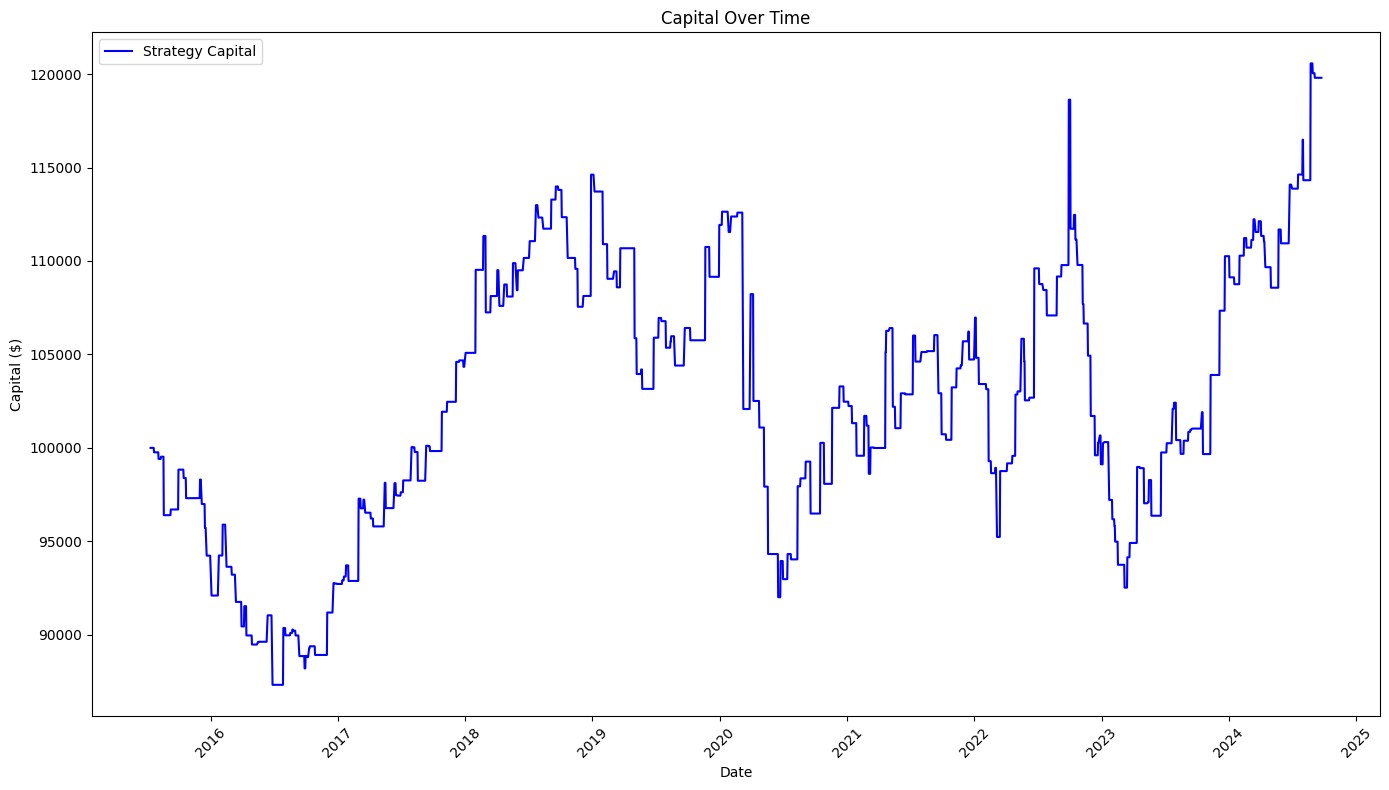

Final Capital: $119799.78
Percentage Return: 19.80%


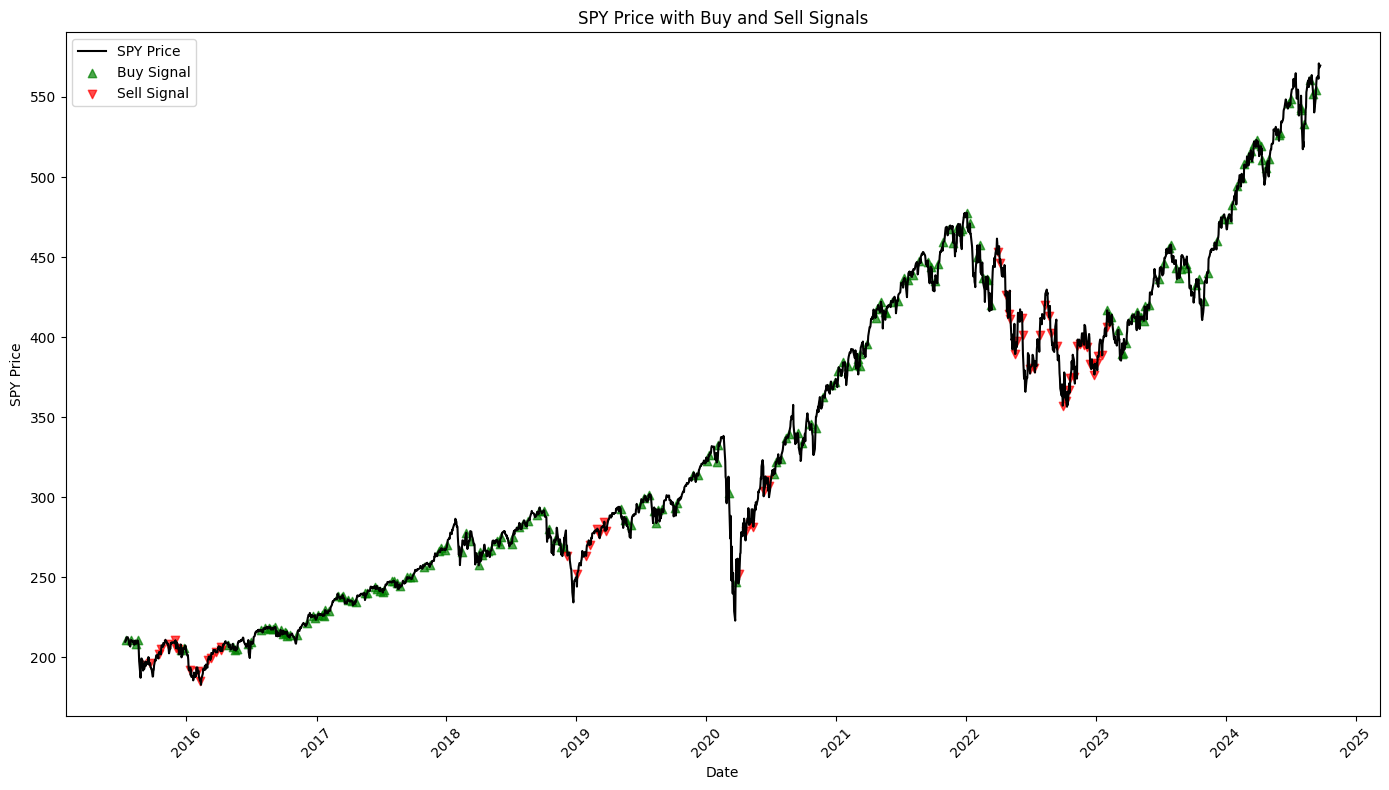

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming ml_trend_indicators and ti_trend_indicators are already loaded with proper 'Date', 'Predicted Trend_ML', and 'Predicted Trend_TI' columns
# Assuming spy_data is the DataFrame that has SPY prices with 'Close' prices and 'Date' as the index or a column

# Combine the ML and Technical Indicators DataFrames on the 'Date' column
combined_trends = pd.merge(ml_trend_indicators, ti_trend_indicators, on='Date', suffixes=('_ML', '_TI'))

# Align spy_data to combined_trends based on the 'Date' column
spy_prices = spy_data[['Close']].reset_index().rename(columns={'index': 'Date'})
combined_trends = pd.merge(combined_trends, spy_prices, on='Date')

# Create a new DataFrame to store the strategy results
combined_trends['Position'] = 0  # 1 for long, -1 for short, 0 for no position
combined_trends['Capital'] = 100000  # Start with $100,000 in capital
combined_trends['Trade'] = np.nan  # Store trade information

# Initial parameters
initial_capital = 100000
capital = initial_capital
position = 0  # 1 for long, -1 for short, 0 for no position
share_price = 0

# Implement the strategy
for i in range(1, len(combined_trends)):
    ml_trend = combined_trends['Predicted Trend_ML'].iloc[i]
    ti_trend = combined_trends['Predicted Trend_TI'].iloc[i]
    spy_price = combined_trends['Close'].iloc[i]

    # If both trends indicate an uptrend, buy SPY (if no position is currently open)
    if ml_trend == 'Uptrend' and ti_trend == 'Uptrend' and position == 0:
        combined_trends.loc[i, 'Position'] = 1  # Go long (buy)
        position = 1
        share_price = spy_price  # Store the price at which SPY was bought
        combined_trends.loc[i, 'Trade'] = 'Buy'

    # If both trends indicate a downtrend, sell SPY (if no position is currently open)
    elif ml_trend == 'Downtrend' and ti_trend == 'Downtrend' and position == 0:
        combined_trends.loc[i, 'Position'] = -1  # Go short (sell)
        position = -1
        share_price = spy_price  # Store the price at which SPY was sold
        combined_trends.loc[i, 'Trade'] = 'Sell'

    # If the trends differ, close any open position
    elif ml_trend != ti_trend and position != 0:
        combined_trends.loc[i, 'Position'] = 0  # Close position
        if position == 1:  # If long, sell SPY
            capital += (spy_price - share_price) * (capital / share_price)
        elif position == -1:  # If short, cover SPY
            capital += (share_price - spy_price) * (capital / share_price)
        position = 0  # No position is open
        combined_trends.loc[i, 'Trade'] = 'Close'
        share_price = 0  # Reset share price

    # Update the capital for each step
    combined_trends.loc[i, 'Capital'] = capital

# Step 5: Calculate final performance
final_capital = combined_trends['Capital'].iloc[-1]
percentage_return = ((final_capital - initial_capital) / initial_capital) * 100

# Print final results
print(f"Final Capital: ${final_capital:.2f}")
print(f"Percentage Return: {percentage_return:.2f}%")

# Display the trend output
print("\nTrend Output Data Table:")
print(combined_trends[['Date', 'Predicted Trend_ML', 'Predicted Trend_TI', 'Position', 'Capital', 'Trade']].tail(20))

# Plot capital over time
plt.figure(figsize=(14, 8))
plt.plot(combined_trends['Date'], combined_trends['Capital'], label='Strategy Capital', color='blue')
plt.title('Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Capital ($)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Buy/Sell signals on SPY price chart
plt.figure(figsize=(14, 8))
plt.plot(combined_trends['Date'], combined_trends['Close'], label='SPY Price', color='black')

buy_signals = combined_trends[combined_trends['Trade'] == 'Buy']
sell_signals = combined_trends[combined_trends['Trade'] == 'Sell']
# Print final results
print(f"Final Capital: ${final_capital:.2f}")
print(f"Percentage Return: {percentage_return:.2f}%")

plt.scatter(buy_signals['Date'], buy_signals['Close'], color='green', label='Buy Signal', marker='^', alpha=0.7)
plt.scatter(sell_signals['Date'], sell_signals['Close'], color='red', label='Sell Signal', marker='v', alpha=0.7)
# Final results
final_capital = combined_trends['Capital'].iloc[-1]
percentage_return = ((final_capital - initial_capital) / initial_capital) * 100

plt.title('SPY Price with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('SPY Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-5-082f9764a918>:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Buy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  combined_trends.loc[i, 'Trade'] = 'Buy'  # Explicitly assigning string


Take profit triggered at 234.33999633789062 on 2018-12-24 00:00:00
Stop loss triggered at 293.8699951171875 on 2019-04-29 00:00:00
Stop loss triggered at 274.2300109863281 on 2020-03-09 00:00:00
Stop loss triggered at 264.8599853515625 on 2020-04-06 00:00:00
SPY Initial Price: $209.77
SPY Final Price: $571.30
SPY Return: 172.35%
SPY Annualized Return: 11.51%

Final Strategy Capital: $861239.84
Strategy Return: 761.24%


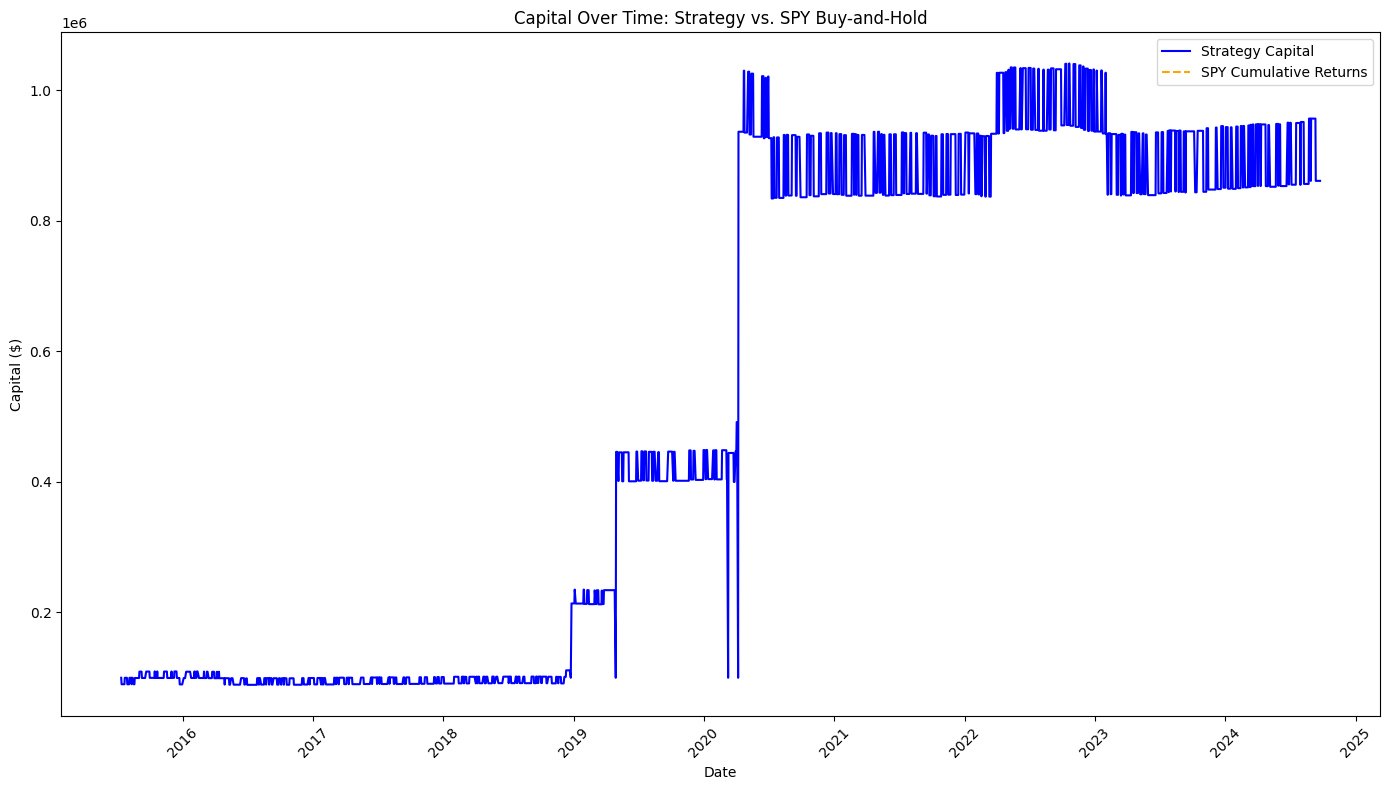

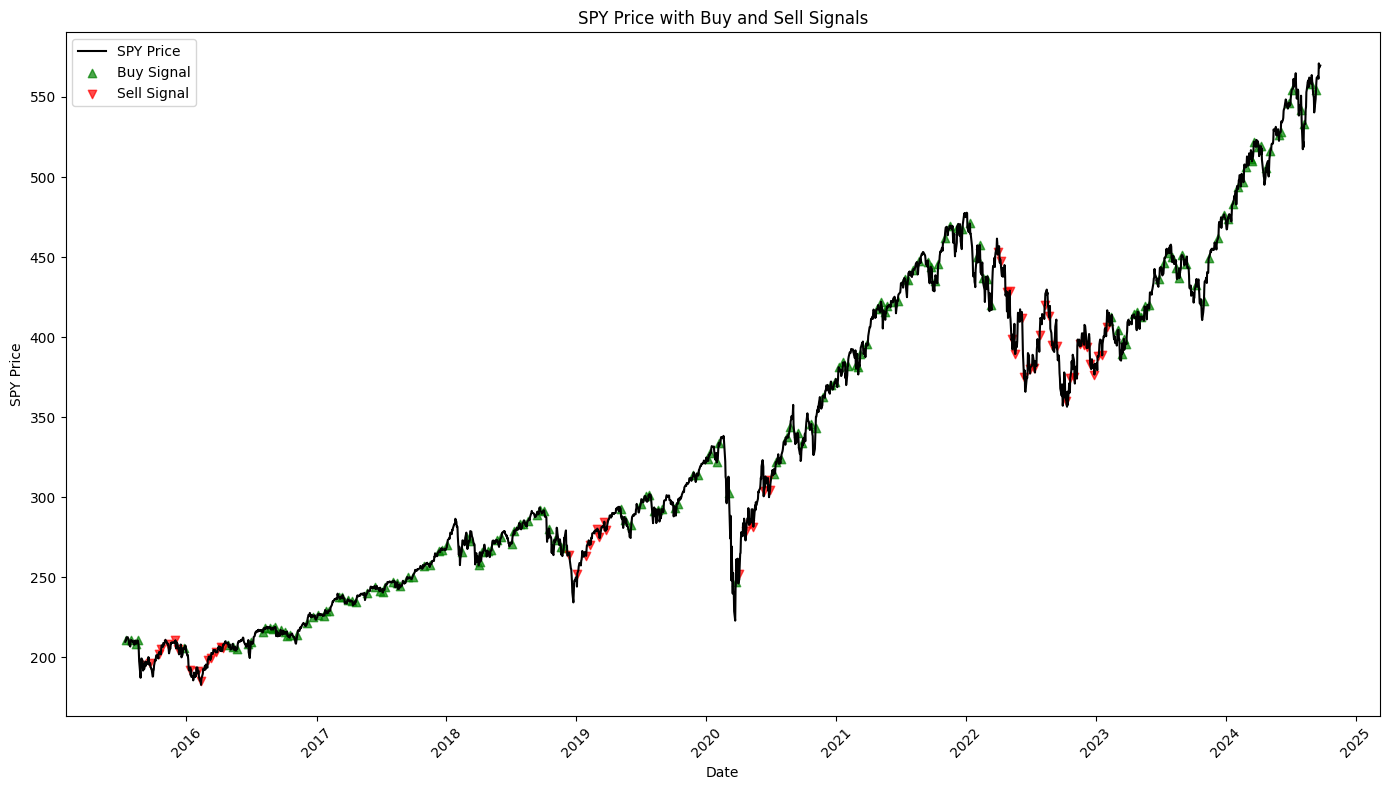

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Merge the trend indicator data
combined_trends = pd.merge(ml_trend_indicators, ti_trend_indicators, on='Date', suffixes=('_ML', '_TI'))
spy_prices = spy_data[['Close']].reset_index().rename(columns={'index': 'Date'})
combined_trends = pd.merge(combined_trends, spy_prices, on='Date')

# Initialize columns with appropriate types
combined_trends['Position'] = 'None'  # 'Uptrend' for long, 'Downtrend' for short, 'None' for no position
combined_trends['Capital'] = 100000.0  # Start with $100,000 in capital, explicitly as float
combined_trends['Trade'] = np.nan  # Initialize 'Trade' as object type
combined_trends['Stop Loss Triggered'] = False
combined_trends['Take Profit Triggered'] = False

# Parameters for the strategy
initial_capital = 100000
position_size = 0.1  # Use 10% of capital per trade
capital = float(initial_capital)  # Explicitly cast to float
position = 'None'
shares_held = 0
cooldown_period = 2  # Wait 2 days after closing a position
stop_loss_threshold = 0.05  # 5% stop loss
take_profit_threshold = 0.10  # 10% take profit
days_since_last_trade = cooldown_period + 1

# Calculate SPY daily returns and cumulative returns
combined_trends['SPY Returns'] = spy_data['Close'].pct_change().fillna(0)  # Calculate daily returns
combined_trends['SPY Cumulative Returns'] = (1 + combined_trends['SPY Returns']).cumprod() * initial_capital  # Cumulative returns

# SPY summary statistics
spy_initial_price = spy_data['Close'].iloc[0]
spy_final_price = spy_data['Close'].iloc[-1]
spy_return = (spy_final_price / spy_initial_price - 1) * 100
spy_annualized_return = ((1 + spy_return / 100) ** (1 / (len(spy_data) / 252)) - 1) * 100  # Annualized return, assuming 252 trading days/year

# Implement the strategy with position sizing, stop loss, and take profit
for i in range(1, len(combined_trends)):
    ml_trend = combined_trends['Predicted Trend_ML'].iloc[i]
    ti_trend = combined_trends['Predicted Trend_TI'].iloc[i]
    spy_price = combined_trends['Close'].iloc[i]
    days_since_last_trade += 1

    # Calculate current profit or loss percentage for stop loss/take profit
    if position != 'None' and shares_held > 0:
        current_profit_pct = (spy_price - share_price) / share_price if position == 'Uptrend' else (share_price - spy_price) / share_price

        # Check if stop loss or take profit is triggered
        if current_profit_pct <= -stop_loss_threshold:
            combined_trends.loc[i, 'Stop Loss Triggered'] = True
            print(f"Stop loss triggered at {spy_price} on {combined_trends['Date'].iloc[i]}")
        elif current_profit_pct >= take_profit_threshold:
            combined_trends.loc[i, 'Take Profit Triggered'] = True
            print(f"Take profit triggered at {spy_price} on {combined_trends['Date'].iloc[i]}")

        if combined_trends['Stop Loss Triggered'].iloc[i] or combined_trends['Take Profit Triggered'].iloc[i]:
            combined_trends.loc[i, 'Position'] = 'None'
            capital += shares_held * spy_price if position == 'Uptrend' else capital - (shares_held * spy_price)
            shares_held = 0
            position = 'None'
            combined_trends.loc[i, 'Trade'] = 'Close'  # Explicitly assigning string, column is cast as 'object'
            days_since_last_trade = 0
            continue

    # Open new positions based on trend agreement and cooldown period
    if position == 'None' and days_since_last_trade > cooldown_period:
        if ml_trend == 'Uptrend' and ti_trend == 'Uptrend':
            shares_held = (capital * position_size) // spy_price
            capital -= shares_held * spy_price
            position = 'Uptrend'
            share_price = spy_price
            combined_trends.loc[i, 'Position'] = 'Uptrend'
            combined_trends.loc[i, 'Trade'] = 'Buy'  # Explicitly assigning string
            days_since_last_trade = 0
        elif ml_trend == 'Downtrend' and ti_trend == 'Downtrend':
            shares_held = (capital * position_size) // spy_price
            capital += shares_held * spy_price
            position = 'Downtrend'
            share_price = spy_price
            combined_trends.loc[i, 'Position'] = 'Downtrend'
            combined_trends.loc[i, 'Trade'] = 'Sell'  # Explicitly assigning string
            days_since_last_trade = 0

    # Close position if trends differ and position is open
    elif ml_trend != ti_trend and position != 'None':
        combined_trends.loc[i, 'Position'] = 'None'
        if position == 'Uptrend':
            capital += shares_held * spy_price
        elif position == 'Downtrend':
            capital -= shares_held * spy_price
        shares_held = 0
        position = 'None'
        combined_trends.loc[i, 'Trade'] = 'Close'  # Explicitly assigning string
        days_since_last_trade = 0

    # Update capital each step
    combined_trends.loc[i, 'Capital'] = float(capital)  # Ensure it's cast as float

# Final performance evaluation for the trading strategy
final_capital = combined_trends['Capital'].iloc[-1]
percentage_return = ((final_capital - initial_capital) / initial_capital) * 100

# Summary of SPY performance
print(f"SPY Initial Price: ${spy_initial_price:.2f}")
print(f"SPY Final Price: ${spy_final_price:.2f}")
print(f"SPY Return: {spy_return:.2f}%")
print(f"SPY Annualized Return: {spy_annualized_return:.2f}%")

# Print final results for the strategy
print(f"\nFinal Strategy Capital: ${final_capital:.2f}")
print(f"Strategy Return: {percentage_return:.2f}%")

# Plot capital over time against SPY cumulative returns
plt.figure(figsize=(14, 8))
plt.plot(combined_trends['Date'], combined_trends['Capital'], label='Strategy Capital', color='blue')
plt.plot(combined_trends['Date'], combined_trends['SPY Cumulative Returns'], label='SPY Cumulative Returns', color='orange', linestyle='--')
plt.title('Capital Over Time: Strategy vs. SPY Buy-and-Hold')
plt.xlabel('Date')
plt.ylabel('Capital ($)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot buy/sell signals on SPY price chart
plt.figure(figsize=(14, 8))
plt.plot(combined_trends['Date'], combined_trends['Close'], label='SPY Price', color='black')
buy_signals = combined_trends[combined_trends['Trade'] == 'Buy']
sell_signals = combined_trends[combined_trends['Trade'] == 'Sell']
plt.scatter(buy_signals['Date'], buy_signals['Close'], color='green', label='Buy Signal', marker='^', alpha=0.7)
plt.scatter(sell_signals['Date'], sell_signals['Close'], color='red', label='Sell Signal', marker='v', alpha=0.7)
plt.title('SPY Price with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('SPY Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
